In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
from shapely.geometry import Point, box
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
from functools import reduce
proj = ccrs.PlateCarree()

#External functions 
import sys 
from pathlib import Path
import fct.fct_plot_claims as fct_plot_claims
import fct.preprocess_sinclim as preprocess_sinclim
from fct.paths import *
path_save_fig = PATH_FIGURE

In [3]:
# PATH_TRACKS = "/home/estimr3/lhasbini/data_storm/priestley/convert_TE/"
period = "1979-2024WIN"

df_info_storm                       = pd.read_csv(PATH_TRACKS+f"tracks_FR_ALL_24h_{period}_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+f"tracks_FR_ALL_24h_{period}.csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"NH_ALL/tracks_ALL_24h_1979-2024WIN_info_SSI-wgust-v2_r1300.csv", encoding="utf-8")
df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

4439 number of storms


In [4]:
########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]

In [5]:
## Also open the dataset before applying filter on the minimal number of claims 
period_subset = "2008-2009"
sinclim_no_min_claims       = pd.read_csv(PATH_TEMP+f"final_per_year/r{r_sinclim}/"+f"sinclim_{sinclim_version}_storm_{window}_unique-{method}_priestley_ALL_{period_subset}_r{r_sinclim}.csv", low_memory=False)
sinclim_no_min_claims['dat_sin'] = pd.to_datetime(sinclim_no_min_claims['dat_sin'])

#Remove grave sinisters 
sinclim_no_min_claims = sinclim_no_min_claims.loc[sinclim_no_min_claims.num_chg_brut < 150000]

#Remove negative losses
sinclim_no_min_claims = sinclim_no_min_claims.loc[sinclim_no_min_claims.num_chg_brut > 0]

######## Group the impact data over storm events
# sinclim_no_min_claims = sinclim_no_min_claims.loc[sinclim_no_min_claims.storm_id.isin(df_info_storm_impact.storm_id.unique())]
sinclim_no_min_claims = pd.merge(sinclim_no_min_claims, df_info_storm_SSI, on='storm_id', how='left')
sinclim_no_min_claims_storm = sinclim_no_min_claims.groupby(['storm_id']).agg(
#     num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('storm_landing_date', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
    NDR_6h_max   =('NDR_6h_max', 'first'), 
    NDR_24h_max  =('NDR_24h_max', 'first')).reset_index()#, 
#     SSI_FRA_max = ('SSI_FRA', 'first')).reset_index()
sinclim_no_min_claims_storm['storm_landing_date'] = pd.to_datetime(sinclim_no_min_claims_storm['storm_landing_date'])

In [6]:
sinclim_no_min_claims['storm_landing_date'] = pd.to_datetime(sinclim_no_min_claims['storm_landing_date'])

In [7]:
######## Group the impact data over storm events
sinclim = sinclim.loc[sinclim.storm_id.isin(df_info_storm_impact.storm_id.unique())]
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')
sinclim_storm = sinclim.groupby(['storm_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
#     NDR_6h_max   =('NDR_6h_max', 'first'), 
#     NDR_24h_max  =('NDR_24h_max', 'first')
).reset_index()#, 
#     SSI_FRA_max = ('SSI_FRA', 'first')).reset_index()

In [8]:
########## High-Impact storm clusters
windi      = 96
r_cluster  = 700

r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
df_storm_cluster                           = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
df_info_mult_cluster                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
df_info_mult_cluster['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster['storm_landing_date'])

df_info_mult_cluster = pd.merge(df_info_mult_cluster, df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

# windi = 96
# r     = 700

# df_storm_cluster                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+".csv", encoding='utf-8')
# df_info_mult_cluster                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+"_info.csv", encoding='utf-8')
# df_info_mult_cluster['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster['storm_landing_date'])

# df_info_mult_cluster = pd.merge(df_info_mult_cluster, df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

In [9]:
######## Group the impact data over cluster events 
sinclim_clust = sinclim.loc[sinclim.storm_id.isin(df_info_mult_cluster.storm_id.unique())]
sinclim_clust = pd.merge(sinclim_clust, df_info_mult_cluster[["storm_id", "clust_id"]], on='storm_id', how='left')

######## Group the impact data over storm events
sinclim_storm_grp = sinclim_clust.groupby(['storm_id', 'clust_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
#     NDR_6h_max   =('NDR_6h_max', 'first'), 
#     NDR_24h_max  =('NDR_24h_max', 'first'), 
    SSI_FRA_max = ('SSI_FRA', 'first')
).reset_index()

sinclim_clust_grp = sinclim_clust.groupby('clust_id').agg(
    year = ('year', 'first'),
    num_chg_brut =('num_chg_brut_cst', 'sum')).reset_index()

# Case study Lothar/Martin 

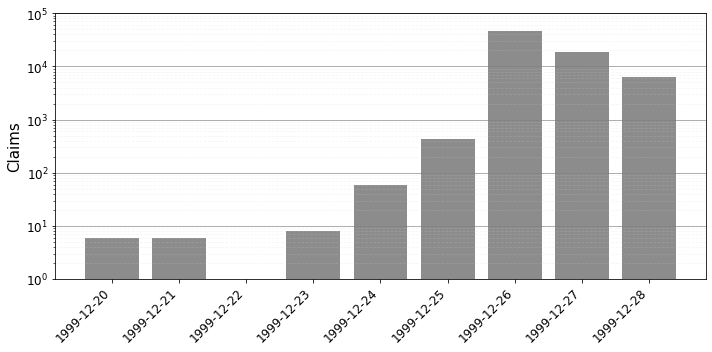

In [10]:
### Only raw claim dates
first_date  = datetime.datetime(year=1999, month=12, day=20)
last_date   = datetime.datetime(year=1999, month=12, day=28)
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]

sinclim_subset_by_day = sinclim_subset.groupby("dat_sin").agg(num_chg_brut_tot = ('num_chg_brut', 'sum'),
                                                   nb_claims           = ('cod_sin', 'count')).reset_index()

# Plot original and concentrated claims
fig = plt.figure(figsize=(10, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Claims', fontsize=15)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(path_save_fig+'nb_claims_days', 
            transparent=True, bbox_inches='tight', dpi=400)
fig.savefig(path_save_fig+'nb_claims_days.svg', 
            format="svg", bbox_inches="tight", dpi=400, transparent=True)

    fig.savefig(path_save_fig+"Cluster_illustration.pdf", format="pdf", transparent=True, dpi=300, bbox_inches='tight')

<ipython-input-17-b48c700b5303>:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, '#f75c03', label='Wgust - min50', basefmt=" ", use_line_collection=True,


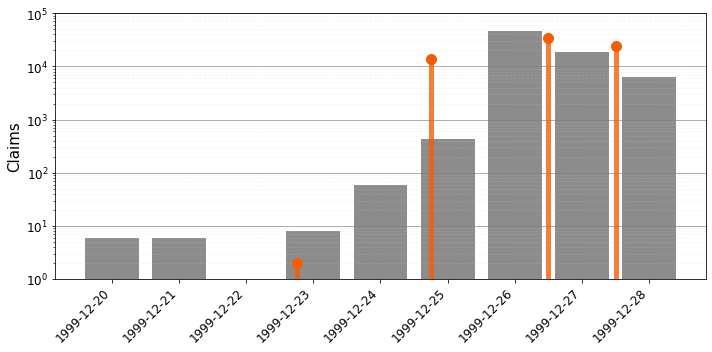

In [17]:
### Only raw claim dates
first_date  = datetime.datetime(year=1999, month=12, day=20)
last_date   = datetime.datetime(year=1999, month=12, day=28)
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]

sinclim_subset_by_day = sinclim_subset.groupby("dat_sin").agg(num_chg_brut_tot = ('num_chg_brut', 'sum'),
                                                   nb_claims           = ('cod_sin', 'count')).reset_index()

sinclim_storm_subset = sinclim_no_min_claims_storm.loc[(sinclim_no_min_claims_storm.storm_landing_date>=first_date) & (sinclim_no_min_claims_storm.storm_landing_date<=last_date)]

# Plot original and concentrated claims
fig = plt.figure(figsize=(10, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Add the identified storms 
stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, '#f75c03', label='Wgust - min50', basefmt=" ", use_line_collection=True, 
         markerfmt='o')
stem_container.stemlines.set_alpha(0.8)
stem_container.stemlines.set_linewidth(5)
stem_container.markerline.set_markersize(10)

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Claims', fontsize=15)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# fig.savefig(path_save_fig+'nb_claims_days', 
#             transparent=True, bbox_inches='tight', dpi=400)
# fig.savefig(path_save_fig+'nb_claims_days.svg', 
#             format="svg", bbox_inches="tight", dpi=400, transparent=True)

<ipython-input-18-b47cf25113a8>:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, '#f75c03', label='Wgust - min50', basefmt=" ", use_line_collection=True,


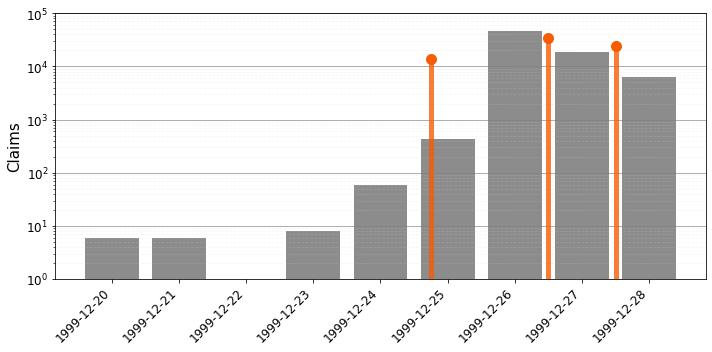

In [18]:
### Only raw claim dates
first_date  = datetime.datetime(year=1999, month=12, day=20)#datetime.datetime(year=2009, month=1, day=10)
last_date   = datetime.datetime(year=1999, month=12, day=28)#datetime.datetime(year=2009, month=1, day=30)
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]

sinclim_subset_by_day = sinclim_subset.groupby("dat_sin").agg(num_chg_brut_tot = ('num_chg_brut', 'sum'),
                                                   nb_claims           = ('cod_sin', 'count')).reset_index()

sinclim_storm_subset = sinclim_storm.loc[(sinclim_storm.storm_landing_date>=first_date) & (sinclim_storm.storm_landing_date<=last_date)]

# Plot original and concentrated claims
fig = plt.figure(figsize=(10, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Add the identified storms 
stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, '#f75c03', label='Wgust - min50', basefmt=" ", use_line_collection=True, 
         markerfmt='o')
stem_container.stemlines.set_alpha(0.8)
stem_container.stemlines.set_linewidth(5)
stem_container.markerline.set_markersize(10)

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Claims', fontsize=15)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# fig.savefig(path_save_fig+'nb_claims_days', 
#             transparent=True, bbox_inches='tight', dpi=400)
# fig.savefig(path_save_fig+'nb_claims_days.svg', 
#             format="svg", bbox_inches="tight", dpi=400, transparent=True)

# Case study Klaus

In [10]:
### Only raw claim dates
first_date  = datetime.datetime(year=2009, month=1, day=15)
last_date   = datetime.datetime(year=2009, month=1, day=30)
sinclim_subset = sinclim.loc[(sinclim.dat_sin>=first_date) & (sinclim.dat_sin<=last_date)]

sinclim_subset_by_day = sinclim_subset.groupby("dat_sin").agg(num_chg_brut_tot = ('num_chg_brut', 'sum'),
                                                   nb_claims           = ('cod_sin', 'count')).reset_index()

sinclim_no_min_storm_subset = sinclim_no_min_claims_storm.loc[(sinclim_no_min_claims_storm.storm_landing_date>=first_date) & (sinclim_no_min_claims_storm.storm_landing_date<=last_date)]

sinclim_storm_subset = sinclim_storm.loc[(sinclim_storm.storm_landing_date>=first_date) & (sinclim_storm.storm_landing_date<=last_date)]

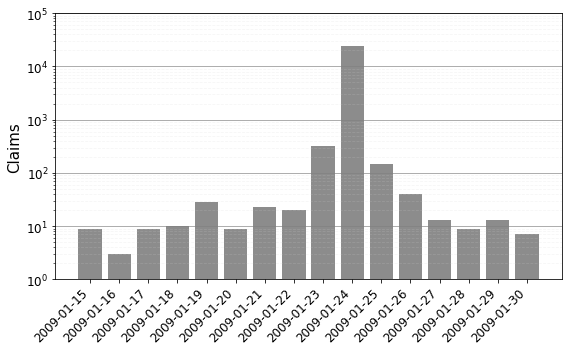

In [53]:
# Plot original and concentrated claims
fig = plt.figure(figsize=(8, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Claims', fontsize=15)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS', 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS.svg', 
#             format="svg", bbox_inches="tight", dpi=300, transparent=True)
# fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS.pdf', 
#             format="pdf", bbox_inches="tight", dpi=300, transparent=True)

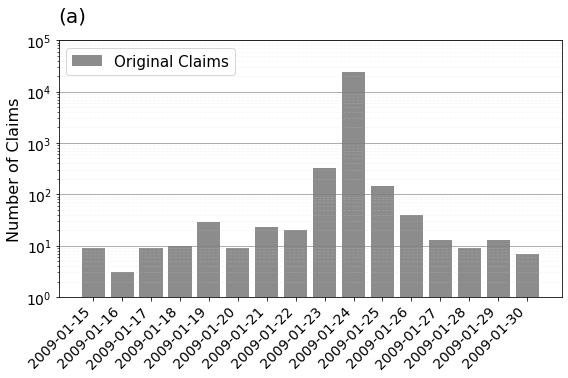

In [17]:
# Plot original and concentrated claims
fig = plt.figure(figsize=(8, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Number of Claims', fontsize=16)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()
plt.title("(a)", loc='left', fontsize=20, y=1.05)

fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS', 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS.svg', 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+'nb_claims_days_Klaus_CS.pdf', 
            format="pdf", bbox_inches="tight", dpi=300)

<ipython-input-18-edd8fc340dae>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  stem_container = plt.stem(sinclim_no_min_storm_subset.storm_landing_date, sinclim_no_min_storm_subset.nb_claims, 'darkred',


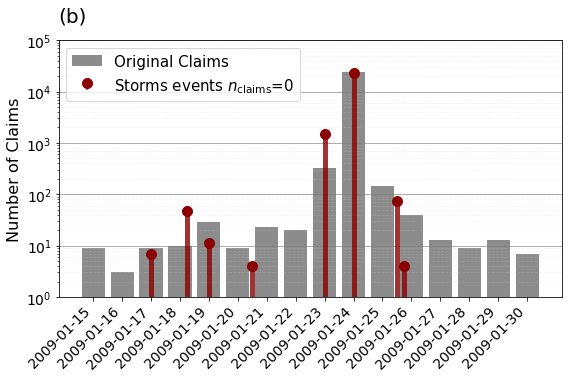

In [18]:
# Plot original and concentrated claims
fig = plt.figure(figsize=(8, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Add the identified storms 
stem_container = plt.stem(sinclim_no_min_storm_subset.storm_landing_date, sinclim_no_min_storm_subset.nb_claims, 'darkred', 
                          label=r"Storms events $n_{\mathrm{claims}}$=0", basefmt=" ", use_line_collection=True, 
         markerfmt='o')
stem_container.stemlines.set_alpha(0.8)
stem_container.stemlines.set_linewidth(5)
stem_container.markerline.set_markersize(10)

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Number of Claims', fontsize=16)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()
plt.title("(b)", loc='left', fontsize=20, y=1.05)

fig.savefig(path_save_fig+'nb_claims_days_storm_no_min_Klaus_CS', 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+'nb_claims_days_storm_no_min_Klaus_CS.svg', 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+'nb_claims_days_storm_no_min_Klaus_CS.pdf', 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

<ipython-input-19-9cd1cde531db>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, 'darkred',


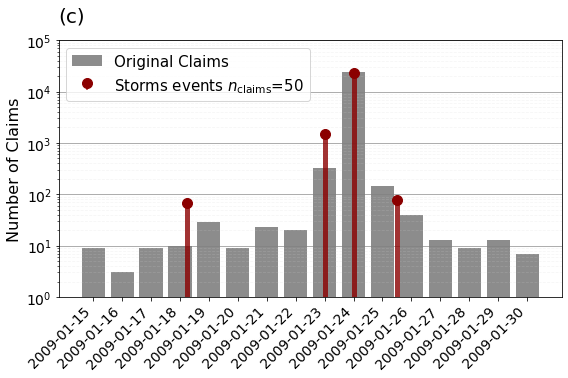

In [19]:
# Plot original and concentrated claims
fig = plt.figure(figsize=(8, 5))
plt.bar(sinclim_subset_by_day.dat_sin, sinclim_subset_by_day.nb_claims, label='Original Claims', alpha=0.9, color='gray')

# Add the identified storms 
stem_container = plt.stem(sinclim_storm_subset.storm_landing_date, sinclim_storm_subset.nb_claims, 'darkred', 
                          label=r"Storms events $n_{\mathrm{claims}}$=50", basefmt=" ", use_line_collection=True, 
         markerfmt='o')
stem_container.stemlines.set_alpha(0.8)
stem_container.stemlines.set_linewidth(5)
stem_container.markerline.set_markersize(10)

# Set up both major and minor ticks on symlog y-axis
plt.yscale('symlog', linthresh=0.1)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))           # Major ticks at 10^0, 10^1, 10^2, etc.
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))  # Minor ticks at 1, 2, 3, ..., 9 within each decade

# Add both major and minor gridlines on y-axis
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.2)

# Labels and title
plt.ylabel('Number of Claims', fontsize=16)
plt.ylim((10**0,10**5))

# Customize x-axis: show only unique dates from `new_dat_sin` with rotation
plt.xticks(sinclim_subset_by_day.dat_sin, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()
plt.title("(c)", loc='left', fontsize=20, y=1.05)

fig.savefig(path_save_fig+'nb_claims_days_storm_final_Klaus_CS', 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+'nb_claims_days_storm_final_Klaus_CS.svg', 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+'nb_claims_days_storm_final_Klaus_CS.pdf', 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)